### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/4_HyperparametersTesting

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Progetto AN2DL/HyperparametersTesting


### Import libraries

In [ ]:
# Hide warnings
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

import logging

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pickle

### Load and process the dataset

In [ ]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save labels in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [ ]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

# Split data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size=0.1,
    stratify=labels
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4503, 96, 96, 3), y_train shape: (4503, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)


### ConvNeXtLarge

In [ ]:
# Import Feature Extractor with specified settings
feature_extractor = tfk.applications.ConvNeXtLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True,
)

In [ ]:
# Define network parameters/callbacks
learning_rate = 1e-3

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.999,
    mode='max',
    min_lr=1e-5
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

### 2 Dense Layer (64 Neurons each)

In [ ]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=64, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=64, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model1 = build_model(feature_extractor, learning_rate)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 64)                98368     
                                                                 
 HiddenActivation1 (Activat  (None, 64)                0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 64)                4160      
                                                                 
 HiddenActivation2 (Activat  (None, 64)                0     

In [ ]:
# Train the model
history1 = model1.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 75s 171ms/step - loss: 0.4159 - accuracy: 0.8064 - val_loss: 0.3567 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 36s 127ms/step - loss: 0.3048 - accuracy: 0.8661 - val_loss: 0.3733 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 125ms/step - loss: 0.2646 - accuracy: 0.8885 - val_loss: 0.3581 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 36s 128ms/step - loss: 0.2319 - accuracy: 0.9030 - val_loss: 0.3689 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 36s 128ms/step - loss: 0.1989 - accuracy: 0.9189 - val_loss: 0.2906 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 36s 128ms/step - loss: 0.1928 - accuracy: 0.9198 - val_loss: 0.2761 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [ ]:
# Save the model
model1.save('2layer_64')
with open('2layer_64/history.pkl', 'wb') as f:
  pickle.dump(history1, f)

### 3 Dense Layer (64 Neurons each)

In [ ]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=64, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=64, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  x = tfkl.Dense(units=64, name='HiddenDense3')(x)
  x = tfkl.Activation('relu', name='HiddenActivation3')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model2 = build_model(feature_extractor, learning_rate)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 64)                98368     
                                                                 
 HiddenActivation1 (Activat  (None, 64)                0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 64)                4160      
                                                                 
 HiddenActivation2 (Activat  (None, 64)                0     

In [ ]:
# Train the model
history2 = model2.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 54s 141ms/step - loss: 0.4378 - accuracy: 0.7995 - val_loss: 0.6079 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 36s 126ms/step - loss: 0.3241 - accuracy: 0.8652 - val_loss: 0.3849 - val_accuracy: 0.8084 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 36s 126ms/step - loss: 0.2781 - accuracy: 0.8743 - val_loss: 0.3198 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 125ms/step - loss: 0.2445 - accuracy: 0.8921 - val_loss: 0.3502 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 35s 126ms/step - loss: 0.2153 - accuracy: 0.9143 - val_loss: 0.3462 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 125ms/step - loss: 0.1867 - accuracy: 0.9249 - val_loss: 0.3257 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [ ]:
# Save the model
model2.save('3layer_64')
with open('3layer_64/history.pkl', 'wb') as f:
  pickle.dump(history2, f)

### 2 Dense Layer (128 Neurons each)

In [ ]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=128, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=128, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model3 = build_model(feature_extractor, learning_rate)
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 128)               196736    
                                                                 
 HiddenActivation1 (Activat  (None, 128)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 128)               16512     
                                                                 
 HiddenActivation2 (Activat  (None, 128)               0     

In [ ]:
# Train the model
history3 = model3.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 53s 141ms/step - loss: 0.4110 - accuracy: 0.8099 - val_loss: 0.3396 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 36s 126ms/step - loss: 0.3134 - accuracy: 0.8608 - val_loss: 0.3017 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2537 - accuracy: 0.8896 - val_loss: 0.3129 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 125ms/step - loss: 0.2308 - accuracy: 0.8987 - val_loss: 0.3703 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 35s 124ms/step - loss: 0.1913 - accuracy: 0.9183 - val_loss: 0.3419 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 36s 126ms/step - loss: 0.1860 - accuracy: 0.9232 - val_loss: 0.2716 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [ ]:
# Save the model
model3.save('2layer_128')
with open('2layer_128/history.pkl', 'wb') as f:
  pickle.dump(history3, f)

### 3 Dense Layer (128 Neurons each)

In [ ]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=128, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=128, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  x = tfkl.Dense(units=128, name='HiddenDense3')(x)
  x = tfkl.Activation('relu', name='HiddenActivation3')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model4 = build_model(feature_extractor, learning_rate)
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 128)               196736    
                                                                 
 HiddenActivation1 (Activat  (None, 128)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 128)               16512     
                                                                 
 HiddenActivation2 (Activat  (None, 128)               0     

In [ ]:
# Train the model
history4 = model4.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 54s 141ms/step - loss: 0.4403 - accuracy: 0.7932 - val_loss: 0.3419 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 36s 126ms/step - loss: 0.3196 - accuracy: 0.8634 - val_loss: 0.3416 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2674 - accuracy: 0.8859 - val_loss: 0.3536 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 126ms/step - loss: 0.2263 - accuracy: 0.9058 - val_loss: 0.3199 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2035 - accuracy: 0.9149 - val_loss: 0.3739 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 36s 127ms/step - loss: 0.1834 - accuracy: 0.9278 - val_loss: 0.3082 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [ ]:
# Save the model
model4.save('3layer_128')
with open('3layer_128/history.pkl', 'wb') as f:
  pickle.dump(history4, f)

### 2 Dense Layer (256 Neurons each)

In [ ]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model5 = build_model(feature_extractor, learning_rate)
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792     
                                                                 
 HiddenActivation2 (Activat  (None, 256)               0     

In [ ]:
# Train the model
history5 = model5.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 54s 141ms/step - loss: 0.4391 - accuracy: 0.8019 - val_loss: 0.3870 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 36s 127ms/step - loss: 0.3213 - accuracy: 0.8590 - val_loss: 0.3242 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 36s 127ms/step - loss: 0.2668 - accuracy: 0.8879 - val_loss: 0.3027 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 36s 126ms/step - loss: 0.2388 - accuracy: 0.9001 - val_loss: 0.2845 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2027 - accuracy: 0.9187 - val_loss: 0.3908 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 125ms/step - loss: 0.1836 - accuracy: 0.9238 - val_loss: 0.3257 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [ ]:
# Save the model
model5.save('2layer_256')
with open('2layer_256/history.pkl', 'wb') as f:
  pickle.dump(history5, f)

### 3 Dense Layer (256 Neurons each)

In [ ]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  x = tfkl.Dense(units=256, name='HiddenDense3')(x)
  x = tfkl.Activation('relu', name='HiddenActivation3')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model6 = build_model(feature_extractor, learning_rate)
model6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792     
                                                                 
 HiddenActivation2 (Activat  (None, 256)               0     

In [ ]:
# Train the model
history6 = model6.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 55s 141ms/step - loss: 0.4342 - accuracy: 0.7941 - val_loss: 0.3480 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 35s 125ms/step - loss: 0.3134 - accuracy: 0.8659 - val_loss: 0.3727 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 126ms/step - loss: 0.2791 - accuracy: 0.8821 - val_loss: 0.2911 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 126ms/step - loss: 0.2345 - accuracy: 0.9027 - val_loss: 0.3002 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 35s 125ms/step - loss: 0.2131 - accuracy: 0.9121 - val_loss: 0.3713 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 124ms/step - loss: 0.1836 - accuracy: 0.9272 - val_loss: 0.2905 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [ ]:
# Save the model
model6.save('3layer_256')
with open('3layer_256/history.pkl', 'wb') as f:
  pickle.dump(history6, f)

### 2 Dense Layer (512 Neurons each)

In [ ]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=512, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=512, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model7 = build_model(feature_extractor, learning_rate)
model7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 512)               786944    
                                                                 
 HiddenActivation1 (Activat  (None, 512)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 512)               262656    
                                                                 
 HiddenActivation2 (Activat  (None, 512)               0     

In [ ]:
# Train the model
history7 = model7.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 55s 142ms/step - loss: 0.4625 - accuracy: 0.7917 - val_loss: 0.3312 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 36s 127ms/step - loss: 0.3086 - accuracy: 0.8683 - val_loss: 0.3249 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 36s 127ms/step - loss: 0.2696 - accuracy: 0.8870 - val_loss: 0.3518 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 126ms/step - loss: 0.2224 - accuracy: 0.9067 - val_loss: 0.3229 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 36s 127ms/step - loss: 0.1899 - accuracy: 0.9229 - val_loss: 0.3312 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 125ms/step - loss: 0.1796 - accuracy: 0.9243 - val_loss: 0.3292 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [ ]:
# Save the model
model7.save('2layer_512')

### 3 Dense Layer (512 Neurons each)

In [ ]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=512, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=512, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  x = tfkl.Dense(units=512, name='HiddenDense3')(x)
  x = tfkl.Activation('relu', name='HiddenActivation3')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model8 = build_model(feature_extractor, learning_rate)
model8.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 512)               786944    
                                                                 
 HiddenActivation1 (Activat  (None, 512)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 512)               262656    
                                                                 
 HiddenActivation2 (Activat  (None, 512)               0     

In [ ]:
# # Train the model
history8 = model8.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 55s 141ms/step - loss: 0.4571 - accuracy: 0.7941 - val_loss: 0.3701 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 36s 128ms/step - loss: 0.3156 - accuracy: 0.8685 - val_loss: 0.3205 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 36s 126ms/step - loss: 0.2795 - accuracy: 0.8825 - val_loss: 0.3401 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 126ms/step - loss: 0.2400 - accuracy: 0.9025 - val_loss: 0.3018 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 35s 126ms/step - loss: 0.2091 - accuracy: 0.9112 - val_loss: 0.2974 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 125ms/step - loss: 0.1918 - accuracy: 0.9203 - val_loss: 0.4167 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [ ]:
# Save the model
model6.save('3layer_512')

### Plot

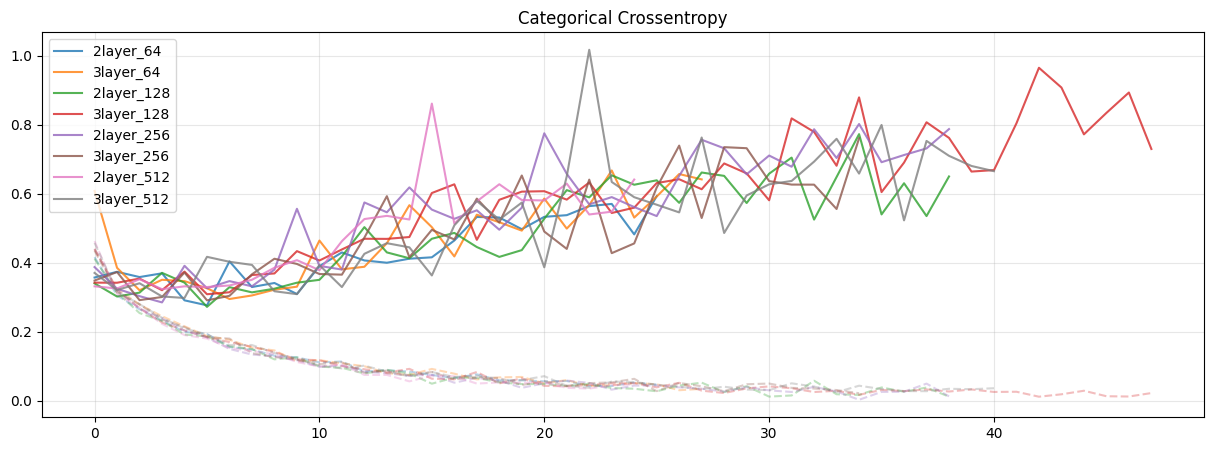

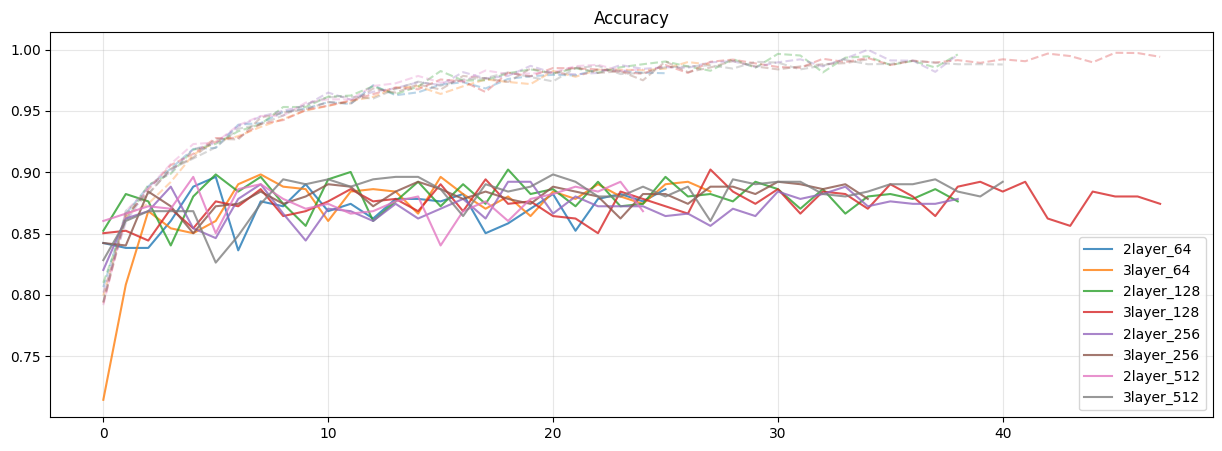

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history1['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history1['val_loss'], label='2layer_64', alpha=.8, color='#1f77b4')
plt.plot(history2['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history2['val_loss'], label='3layer_64', alpha=.8, color='#ff7f0e')
plt.plot(history3['loss'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history3['val_loss'], label='2layer_128', alpha=.8, color='#2ca02c')
plt.plot(history4['loss'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history4['val_loss'], label='3layer_128', alpha=.8, color='#d62728')
plt.plot(history5['loss'], alpha=.3, color='#9467bd', linestyle='--')
plt.plot(history5['val_loss'], label='2layer_256', alpha=.8, color='#9467bd')
plt.plot(history6['loss'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history6['val_loss'], label='3layer_256', alpha=.8, color='#8c564b')
plt.plot(history7['loss'], alpha=.3, color='#e377c2', linestyle='--')
plt.plot(history7['val_loss'], label='2layer_512', alpha=.8, color='#e377c2')
plt.plot(history8['loss'], alpha=.3, color='#7f7f7f', linestyle='--')
plt.plot(history8['val_loss'], label='3layer_512', alpha=.8, color='#7f7f7f')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history1['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history1['val_accuracy'], label='2layer_64', alpha=.8, color='#1f77b4')
plt.plot(history2['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history2['val_accuracy'], label='3layer_64', alpha=.8, color='#ff7f0e')
plt.plot(history3['accuracy'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history3['val_accuracy'], label='2layer_128', alpha=.8, color='#2ca02c')
plt.plot(history4['accuracy'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history4['val_accuracy'], label='3layer_128', alpha=.8, color='#d62728')
plt.plot(history5['accuracy'], alpha=.3, color='#9467bd', linestyle='--')
plt.plot(history5['val_accuracy'], label='2layer_256', alpha=.8, color='#9467bd')
plt.plot(history6['accuracy'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history6['val_accuracy'], label='3layer_256', alpha=.8, color='#8c564b')
plt.plot(history7['accuracy'], alpha=.3, color='#e377c2', linestyle='--')
plt.plot(history7['val_accuracy'], label='2layer_512', alpha=.8, color='#e377c2')
plt.plot(history8['accuracy'], alpha=.3, color='#7f7f7f', linestyle='--')
plt.plot(history8['val_accuracy'], label='3layer_512', alpha=.8, color='#7f7f7f')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()
plt.savefig('layer.png')